## Compute and store binned Lagrangian diagnostics : 

Mean velocity fields : 
1) Total velocity : $<u>$, $<v>$, $<\sqrt{u^2+v^2}>$
2) Eulerian interpolated mean velocity : $<\bar u_i>$, $<\bar v_i>$, $<\sqrt{\bar u_i^2+\bar v_i^2}>$
3) Total velocity minus Eulerian mean velocity : $<(u-\bar u_i)>$, $<(v-\bar v_i)>$
4) Total velocity minus Lagrangian mean velocity : $<(u-<u>)>$, $<(v-<v>)>$

Mean of squared fields : 
1) Total velocity : $<u^2>$, $<v^2>$, $<u^2+v^2>$
2) Eulerian interpolated mean velocity : $<\bar u_i^2>$, $<\bar v_i^2>$, $<\bar u_i^2+\bar v_i^2>$
3) Total velocity minus Eulerian mean velocity : $<(u-\bar u_i)^2>$, $<(v-\bar v_i)^2>$, $<(u-\bar u_i)^2+(v-\bar v_i)^2>$
4) Total velocity minus Lagrangian mean velocity : $<(u-<u>)^2>$, $<(v-<v>)^2>$, $<(u-<u>)^2+(v-<v>)^2>$



In [1]:
import numpy as np

import xarray as xr
from matplotlib import pyplot as plt
%matplotlib inline

import dask.dataframe as dd
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import pandas as pd

import mitequinox.utils as ut
import mitequinox.plot as pl
import mitequinox.parcels as pa
from xmitgcm import llcreader

from fsspec.implementations.local import LocalFileSystem

INFO: Compiled ParcelsRandom ==> /dev/shm/pbs.5161704.datarmor0/parcels-502090/libparcels_random_05d75969-a258-4234-90b5-fd0b58def6ca.so


In [2]:
from dask.distributed import Client, LocalCluster
#
#cluster = LocalCluster()
#
from dask_jobqueue import PBSCluster
cluster = PBSCluster() #processes=7, cores=7
w = cluster.scale(jobs=3
                 )
#
client = Client(cluster)


In [3]:
client

Client Scheduler: tcp://10.148.1.44:57173 Dashboard: http://10.148.1.44:8787/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


### Load dataframe

In [7]:
root_dir = '/home1/datawork/aponte/parcels/'
run_name = 'global_extra_T365j_dt1j_dij50'

p = pa.parcels_output(root_dir+run_name, parquets=['time_mean'])
df = p.df['time_mean']

df = pa.degs2ms(df) #Convert in m/s 

#df = df.persist()

In [8]:
#Subdataframe : we keep only velocity field
df_uv = df.drop(columns = ['sea_level','temperature','salinity','SST_interp','SSS_interp','Eta_interp']) #drop unused variables

df_uv = df_uv.rename(columns={'SSU_interp':'mean_zonal_velocity','SSV_interp':'mean_meridional_velocity'})#.persist()

### Binned statistics : 

In [9]:
# geographical bins
dl = 1.
lon_bins = np.arange(-180.,180., dl)
lat_bins = np.arange(-90.,90., dl)


In [10]:
import pandas as pd
df_uv['lon'] = (df_uv['lon']+180)%360 - 180
df_uv['lon_cut'] = df_uv['lon'].map_partitions(pd.cut, lon_bins)
df_uv['lat_cut'] = df_uv['lat'].map_partitions(pd.cut, lat_bins)


In [11]:
df_uv = df_uv.persist()

In [12]:
df_uv

,trajectory,lat,lon,z,zonal_velocity,meridional_velocity,mean_zonal_velocity,mean_meridional_velocity,lon_cut,lat_cut
npartitions=749,,,,,,,,,,
,int32,float64,float64,float64,float64,float32,float64,float64,category[known],category[known]
,...,...,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...


In [13]:
df_reset = df_uv.reset_index().persist()

In [14]:
group = ['lon_cut','lat_cut']
df_mean = df_reset.drop(columns=['trajectory','z','lat','lon']
                  ).groupby(group).mean().compute()

In [15]:
df_mean = df_mean.rename(columns={V:V+'_binned' for V in df_mean.columns})

df_merged = (df_reset
             .merge(df_mean.reset_index(), on=["lon_cut", "lat_cut"])
             .persist()
            )
df_merged

,time,trajectory,lat,lon,z,zonal_velocity,meridional_velocity,mean_zonal_velocity,mean_meridional_velocity,lon_cut,lat_cut,zonal_velocity_binned,meridional_velocity_binned,mean_zonal_velocity_binned,mean_meridional_velocity_binned
npartitions=749,,,,,,,,,,,,,,,
,datetime64[ns],int32,float64,float64,float64,float64,float32,float64,float64,category[known],category[known],float64,float64,float64,float64
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...


In [16]:
df_merged = df_merged.set_index('time').persist()

In [17]:
for V in ['zonal_velocity','meridional_velocity']:
    df_merged[V+'_bprime'] = (df_merged[V]-df_merged[V+'_binned'])
df_merged = df_merged.persist()

In [18]:
columns = ['zonal_velocity','meridional_velocity']
group = ['lon_cut','lat_cut']
for V in columns:
    df_merged[V+'_iprime'] = df_merged[V].sub(df_merged['mean_'+V])
    df_merged[V+'_binned_iprime'] = df_merged[V].sub(df_merged['mean_'+V+'_binned'])
df_merged = df_merged.persist()

In [19]:
df_merged = df_merged.drop(columns=['lon_cut','lat_cut']).persist()
df_merged.head()

,trajectory,lat,lon,z,zonal_velocity,meridional_velocity,mean_zonal_velocity,mean_meridional_velocity,zonal_velocity_binned,meridional_velocity_binned,mean_zonal_velocity_binned,mean_meridional_velocity_binned,zonal_velocity_bprime,meridional_velocity_bprime,zonal_velocity_iprime,zonal_velocity_binned_iprime,meridional_velocity_iprime,meridional_velocity_binned_iprime
time,,,,,,,,,,,,,,,,,,
2011-11-15,39000000,57.835732,-178.867081,0.0,0.0,0.0,-0.002461,-0.006017,-0.016686,-0.012554,-0.018123,-0.006659,0.016686,0.012554,0.002461,0.018123,0.006017,0.006659
2011-11-15,43000698,-47.431129,-78.739586,0.0,0.0,0.0,0.099954,0.042124,0.090000,-0.020012,0.088468,-0.003191,-0.090000,0.020012,-0.099954,-0.088468,-0.042124,0.003191
2011-11-15,35001148,-25.350487,-130.947922,0.0,0.0,0.0,-0.006729,-0.028914,-0.018260,-0.001465,-0.007729,-0.010520,0.018260,0.001465,0.006729,0.007729,0.028914,0.010520
2011-11-15,43000697,-48.087612,-78.739586,0.0,0.0,0.0,0.129855,-0.030256,0.134520,-0.035810,0.139656,-0.024530,-0.134520,0.035810,-0.129855,-0.139656,0.030256,0.024530
2011-11-15,43000696,-48.736740,-78.739586,0.0,0.0,0.0,0.119153,-0.033374,0.134520,-0.035810,0.139656,-0.024530,-0.134520,0.035810,-0.119153,-0.139656,0.033374,0.024530


### Store total velocity minus mean velocity

In [20]:
ds, dirs = pa.load_logs(root_dir, run_name)
pa.store_parquet(dirs["parquets"], df_merged, overwrite=True, name="time_prime")

No reindexing
deleting existing archive: /home1/datawork/aponte/parcels/global_extra_T365j_dt1j_dij50/parquets/time_prime
create new archive: /home1/datawork/aponte/parcels/global_extra_T365j_dt1j_dij50/parquets/time_prime


'/home1/datawork/aponte/parcels/global_extra_T365j_dt1j_dij50/parquets/time_prime'

### Persist dataframe with total velocity, mean velocity (binned and Eulereian interpolated) and residual velcoity (total minus mean)

In [5]:
root_dir = '/home1/datawork/aponte/parcels/'
run_name = 'global_extra_T365j_dt1j_dij50'

p = pa.parcels_output(root_dir+run_name, parquets=['time_prime'])
df = df = p.df['time_prime']

#df = df.repartition(npartitions=100)
df = df.persist()

In [5]:
#### Add velocity amplitude and kinetic energy 

In [14]:
df['mean_KE'] = df['mean_zonal_velocity']**2+df['mean_meridional_velocity']**2
df['mean_KE_ibinned'] = df['mean_zonal_velocity_binned']**2+df['mean_meridional_velocity_binned']**2
df['mean_KE_binned'] = df['zonal_velocity_binned']**2+df['meridional_velocity_binned']**2

df['EKE'] = df['zonal_velocity_iprime']**2+df['meridional_velocity_iprime']**2
df['EKE_ibinned'] = df['zonal_velocity_binned_iprime']**2+df['meridional_velocity_binned_iprime']**2
df['EKE_binned'] = df['zonal_velocity_bprime']**2+df['meridional_velocity_bprime']**2

df['KE'] = df['zonal_velocity']**2+df['meridional_velocity']**2
df = df.persist()

In [15]:
for V in df.loc[:, df.columns.str.startswith('mean_KE')].columns:
    df['velocity_amplitude'+V[7:]] = np.sqrt(df[V])
df = df.persist()

In [7]:
for V in ['zonal_velocity','meridional_velocity','zonal_velocity_iprime','meridional_velocity_iprime','zonal_velocity_bprime','meridional_velocity_bprime']:
     df[V+'_square'] = df[V]**2
df = df.persist()

In [16]:
df.head()

,trajectory,lat,lon,z,zonal_velocity,meridional_velocity,mean_zonal_velocity,mean_meridional_velocity,zonal_velocity_binned,meridional_velocity_binned,...,mean_KE,mean_KE_ibinned,mean_KE_binned,EKE,EKE_ibinned,EKE_binned,KE,velocity_amplitude,velocity_amplitude_ibinned,velocity_amplitude_binned
time,,,,,,,,,,,,,,,,,,,,,
2011-11-15,39000000,57.835732,-178.867081,0.0,0.0,0.0,-0.002461,-0.006017,-0.016686,-0.012554,...,0.000042,0.000373,0.000436,0.000042,0.000373,0.000436,0.0,0.006500,0.019308,0.020881
2011-11-15,43000698,-47.431129,-78.739586,0.0,0.0,0.0,0.099954,0.042124,0.090000,-0.020012,...,0.011765,0.007837,0.008501,0.011765,0.007837,0.008501,0.0,0.108468,0.088525,0.092198
2011-11-15,35001148,-25.350487,-130.947922,0.0,0.0,0.0,-0.006729,-0.028914,-0.018260,-0.001465,...,0.000881,0.000170,0.000336,0.000881,0.000170,0.000336,0.0,0.029686,0.013054,0.018318
2011-11-15,43000697,-48.087612,-78.739586,0.0,0.0,0.0,0.129855,-0.030256,0.134520,-0.035810,...,0.017778,0.020106,0.019378,0.017778,0.020106,0.019378,0.0,0.133333,0.141794,0.139205
2011-11-15,43000696,-48.736740,-78.739586,0.0,0.0,0.0,0.119153,-0.033374,0.134520,-0.035810,...,0.015311,0.020106,0.019378,0.015311,0.020106,0.019378,0.0,0.123738,0.141794,0.139205


In [20]:
#### Binning and averaging (several datasets created to lighten)

In [7]:
df_sub = df.loc[:, df.columns.str.startswith('mean_')].persist()

In [8]:
df_sub['binned_zonal_velocity'] = df['zonal_velocity_binned']
df_sub['binned_meridional_velocity'] = df['meridional_velocity_binned']
df_sub['lon'] = df['lon']
df_sub['lat'] = df['lat']

In [9]:
dl = 1.
lon = np.arange(-180,180, dl)
lat = np.arange(-90, 90, dl)

df['lon'] = (df['lon']+180)%360 - 180
df['lon_cut'] = df['lon'].map_partitions(pd.cut, lon)
df['lat_cut'] = df['lat'].map_partitions(pd.cut, lat)
df = df.persist()

### Compute mean : 

In [17]:
df_mean = df.drop(columns=['trajectory','z']).groupby([df.lon_cut, df.lat_cut]).mean().compute()

df_mean = pa.add_geodata(df_mean)
#count['density'] = count['count']/count['area']

df_mean = (df_mean
 #     .drop(columns=['Coordinates'])
      .set_index(['lon', 'lat'])
     .to_xarray()
    )

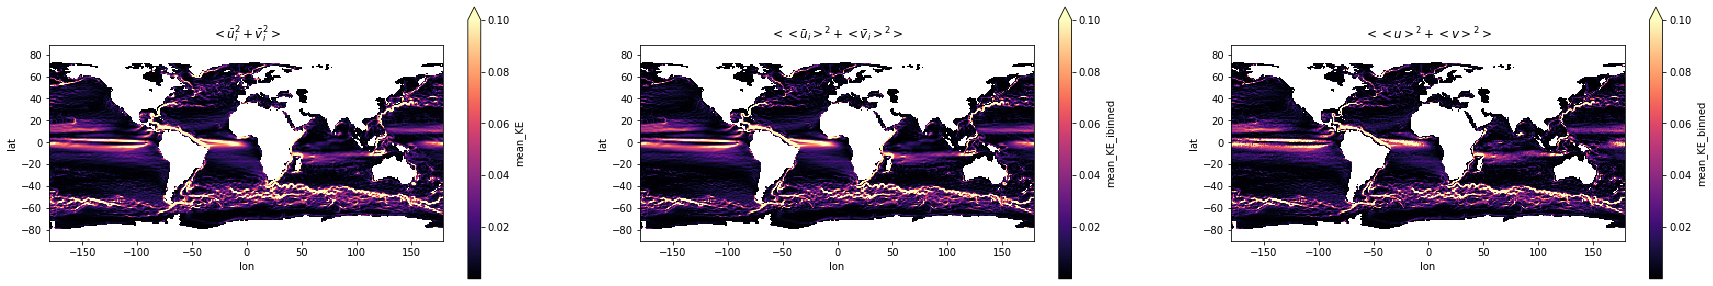

In [18]:
vmax = 0.1
fig,ax = plt.subplots(1,3,figsize=(30,5))
df_mean.mean_KE.plot(y='lat',vmax=vmax,cmap='magma',ax=ax[0])
df_mean.mean_KE_ibinned.plot(y='lat',vmax=vmax,cmap='magma',ax=ax[1])
df_mean.mean_KE_binned.plot(y='lat',vmax=vmax,cmap='magma',ax=ax[2])
for title,a in zip([r'$<\bar u_i^2+\bar v_i^2>$',r'$<<\bar u_i>^2+<\bar v_i>^2>$',r'$<<u>^2+<v>^2>$'],ax):
    a.set_aspect('equal');a.set_title(title)

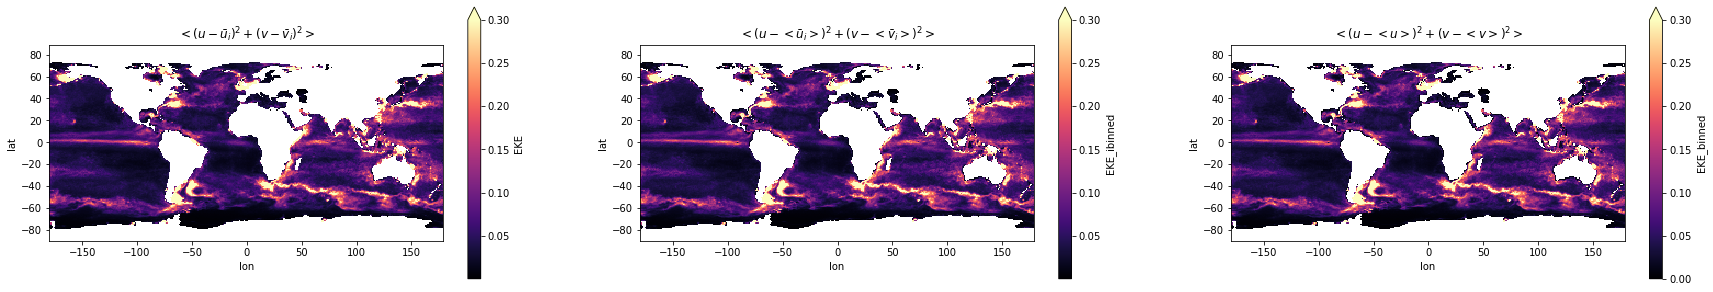

In [20]:
vmax = 0.3
fig,ax = plt.subplots(1,3,figsize=(30,5))
df_mean.EKE.plot(y='lat',vmax=vmax,cmap='magma',ax=ax[0])
df_mean.EKE_ibinned.plot(y='lat',vmax=vmax,cmap='magma',ax=ax[1])
df_mean.EKE_binned.plot(y='lat',vmax=vmax,cmap='magma',ax=ax[2])
for title,a in zip([r'$<(u-\bar u_i)^2+(v-\bar v_i)^2>$',r'$<(u-<\bar u_i>)^2+(v-<\bar v_i>)^2>$',r'$<(u-<u>)^2+(v-<v>)^2>$'],ax):
    a.set_aspect('equal');a.set_title(title)

### Store diagnostics

In [21]:
df_mean.attrs.update(**{'run_name': run_name,'dl': dl})

In [22]:
df_mean

<xarray.Dataset>
Dimensions:                            (lat: 179, lon: 359)
Coordinates:
  * lon                                (lon) float64 -179.5 -178.5 ... 178.5
  * lat                                (lat) float64 -89.5 -88.5 ... 87.5 88.5
Data variables: (12/30)
    zonal_velocity                     (lon, lat) float64 nan nan ... nan nan
    meridional_velocity                (lon, lat) float64 nan nan ... nan nan
    mean_zonal_velocity                (lon, lat) float64 nan nan ... nan nan
    mean_meridional_velocity           (lon, lat) float64 nan nan ... nan nan
    zonal_velocity_binned              (lon, lat) float64 nan nan ... nan nan
    meridional_velocity_binned         (lon, lat) float64 nan nan ... nan nan
    ...                                 ...
    EKE_ibinned                        (lon, lat) float64 nan nan ... nan nan
    EKE_binned                         (lon, lat) float64 nan nan ... nan nan
    KE                                 (lon, lat) float64 nan nan ... nan nan
    velocity_amplitude                 (lon, lat) float64 nan nan ... nan nan
    velocity_amplitude_ibinned         (lon, lat) float64 nan nan ... nan nan
    velocity_amplitude_binned          (lon, lat) float64 nan nan ... nan nan
Attributes:
    run_name:  global_extra_T365j_dt1j_dij50
    dl:        1.0

In [23]:
#store dataset in diagnostics directory
p.store_diagnostic("L_dl"+str(dl)+"_stats", df_mean,overwrite=True)

L_dl1.0_stats diagnostics stored in /home1/datawork/aponte/parcels/global_extra_T365j_dt1j_dij50/diagnostics/L_dl1.0_stats.zarr


### Load diagnostics

In [5]:
root_dir = '/home1/datawork/aponte/parcels/'
run_name = 'global_extra_T365j_dt1j_dij50'

p = pa.parcels_output(root_dir+run_name, parquets=['time_prime'])
df_mean = p.load_diagnostic('L_dl1.0_stats.zarr')

In [6]:
df_mean.load()

<xarray.Dataset>
Dimensions:                            (lat: 179, lon: 359)
Coordinates:
  * lat                                (lat) float64 -89.5 -88.5 ... 87.5 88.5
  * lon                                (lon) float64 -179.5 -178.5 ... 178.5
Data variables: (12/30)
    EKE                                (lon, lat) float64 nan nan ... nan nan
    EKE_binned                         (lon, lat) float64 nan nan ... nan nan
    EKE_ibinned                        (lon, lat) float64 nan nan ... nan nan
    KE                                 (lon, lat) float64 nan nan ... nan nan
    mean_KE                            (lon, lat) float64 nan nan ... nan nan
    mean_KE_binned                     (lon, lat) float64 nan nan ... nan nan
    ...                                 ...
    zonal_velocity_binned_iprime       (lon, lat) float64 nan nan ... nan nan
    zonal_velocity_bprime              (lon, lat) float64 nan nan ... nan nan
    zonal_velocity_bprime_square       (lon, lat) float64 nan nan ... nan nan
    zonal_velocity_iprime              (lon, lat) float64 nan nan ... nan nan
    zonal_velocity_iprime_square       (lon, lat) float64 nan nan ... nan nan
    zonal_velocity_square              (lon, lat) float64 nan nan ... nan nan
Attributes:
    dl:        1.0
    run_name:  global_extra_T365j_dt1j_dij50

### Visualization : 

#### Mean flow : Lagrangian raw velocity, $<u>$

$<.>$ : average over bin and time


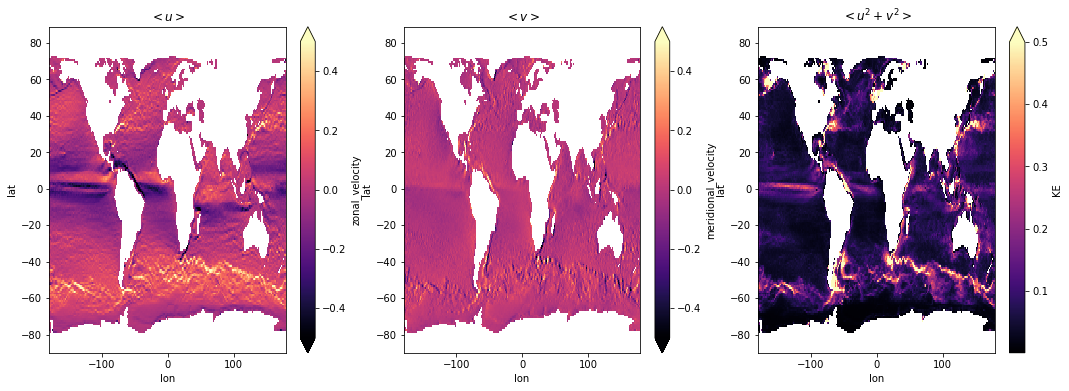

In [7]:
columns = ['zonal_velocity','meridional_velocity','KE']
figsize=(6*len(columns),6)
fig,axs = plt.subplots(1,len(columns),figsize=figsize)#,subplot_kw=dict(projection=projection))
for V, ax,title in zip(columns,axs,[r'$<u>$',r'$<v>$',r'$<u^2+v^2>$']):    
    df_mean[V].plot(ax=ax,x='lon',vmax=0.5,cmap='magma')
    ax.set_title(title)

#### Mean flow : Interpolated Eulerian mean, $<u_i>$ and $<u_i'>=<u-\bar u_i>$
$<.>$ : average over bin and time

$\bar .$ : temporal average

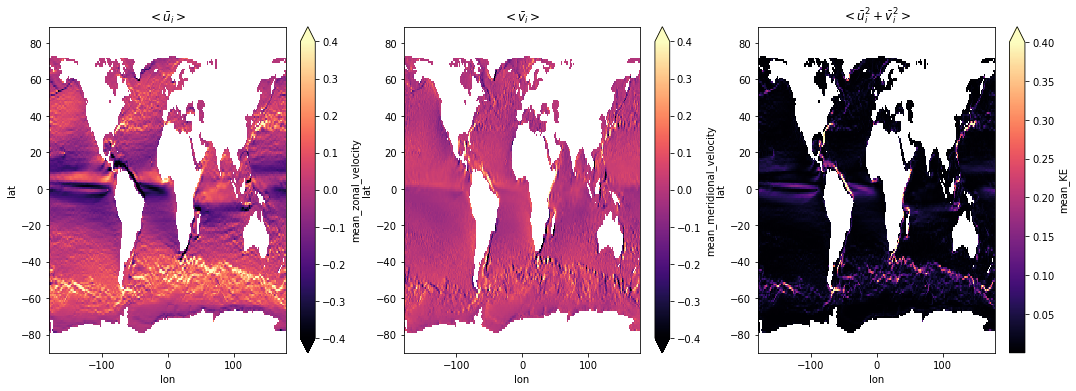

In [11]:
columns = ['mean_zonal_velocity','mean_meridional_velocity','mean_KE']
figsize=(6*len(columns),6)
fig,axs = plt.subplots(1,len(columns),figsize=figsize)#,subplot_kw=dict(projection=projection))
for V, ax,title in zip(columns,axs,[r'$<\bar u_i>$',r'$<\bar v_i>$',r'$<\bar u_i^2+\bar v_i^2>$']):
    df_mean[V].plot(ax=ax,x='lon',vmax=0.4,cmap='magma')
    ax.set_title(title)

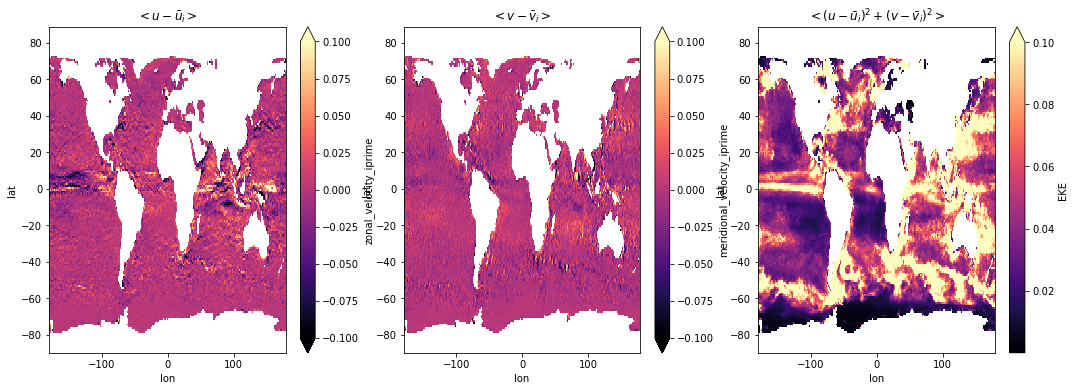

In [13]:
columns = ['zonal_velocity_iprime','meridional_velocity_iprime','EKE']
figsize=(6*len(columns),6)
fig,axs = plt.subplots(1,len(columns),figsize=figsize)#,subplot_kw=dict(projection=projection))
for V, ax,title in zip(columns,axs,[r'$<u-\bar u_i>$',r'$<v-\bar v_i>$',r'$<(u-\bar u_i)^2+(v-\bar v_i)^2>$']):
    df_mean[V].plot(ax=ax,x='lon',vmax=0.1,cmap='magma')
    ax.set_title(title)

#### Mean flow : Total velocity minus binned mean, $<u_b>$ and $<u_b'>=<u-\bar u_b>$
$<.>$ : average over bin and time

$\bar .$ : temporal and binend average

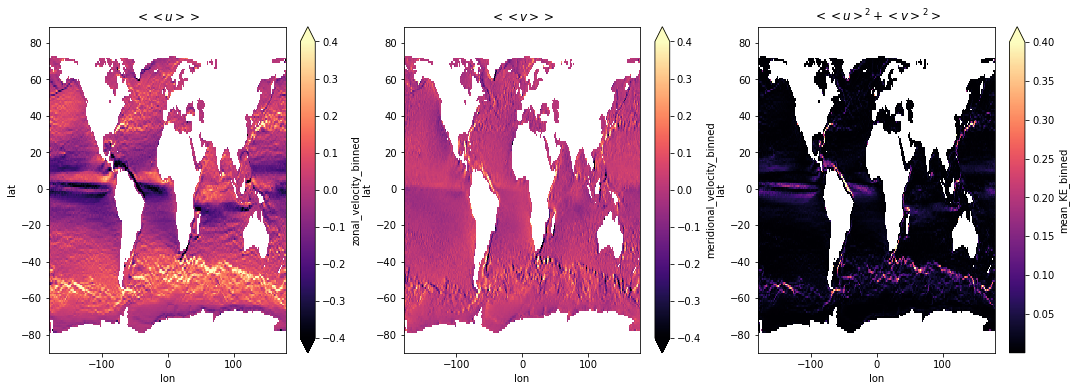

In [17]:
columns = ['zonal_velocity_binned','meridional_velocity_binned','mean_KE_binned']
figsize=(6*len(columns),6)
fig,axs = plt.subplots(1,len(columns),figsize=figsize)#,subplot_kw=dict(projection=projection))
for V, ax,title in zip(columns,axs,[r'$<<u>>$',r'$<<v>>$',r'$<<u>^2+<v>^2>$']):

    df_mean[V].plot(ax=ax,x='lon',vmax=0.4,cmap='magma')
    ax.set_title(title)

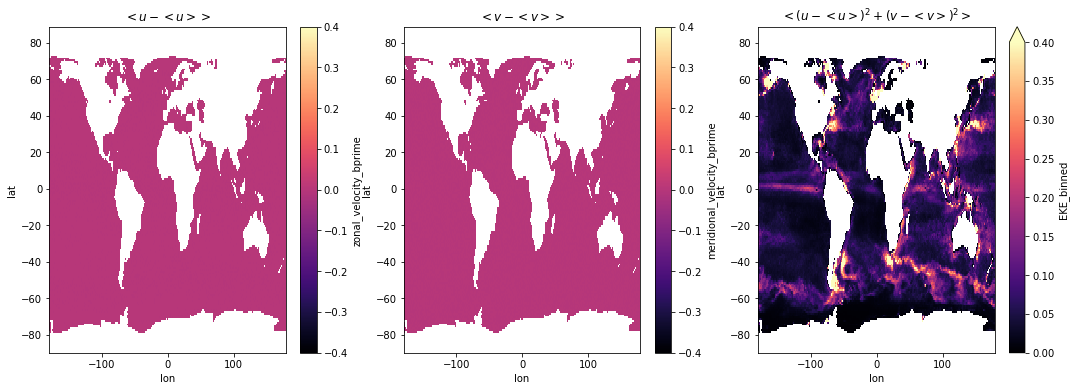

In [20]:
columns = ['zonal_velocity_bprime','meridional_velocity_bprime','EKE_binned']
figsize=(6*len(columns),6)
fig,axs = plt.subplots(1,len(columns),figsize=figsize)#,subplot_kw=dict(projection=projection))
for V, ax,title in zip(columns,axs,[r'$<u-<u>>$',r'$<v-<v>>$',r'$<(u-<u>)^2+(v-<v>)^2>$']):

    df_mean[V].plot(ax=ax,x='lon',vmax=0.4,cmap='magma')
    ax.set_title(title)

#### Variance : $<u^2>$
$<.>$ : average over bin and time

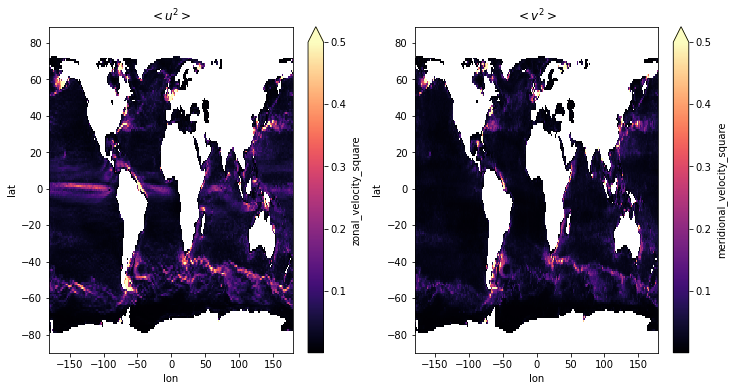

In [23]:
columns = ['zonal_velocity','meridional_velocity']
figsize=(6*len(columns),6)
fig,axs = plt.subplots(1,len(columns),figsize=figsize)#,subplot_kw=dict(projection=projection))
for V, ax,title in zip(columns,axs,[r'$<u^2>$',r'$<v^2>$',r'$<\sqrt{u^2+v^2}>$']):

    df_mean[V+'_square'].plot(ax=ax,x='lon',vmax=0.5,cmap='magma')
    ax.set_title(title)

#### EKE : interpolated mean, $<u_i'^2>=<(u-\bar u_i)^2>$
$<.>$ : average over bin and time

$\bar .$ : temporal average

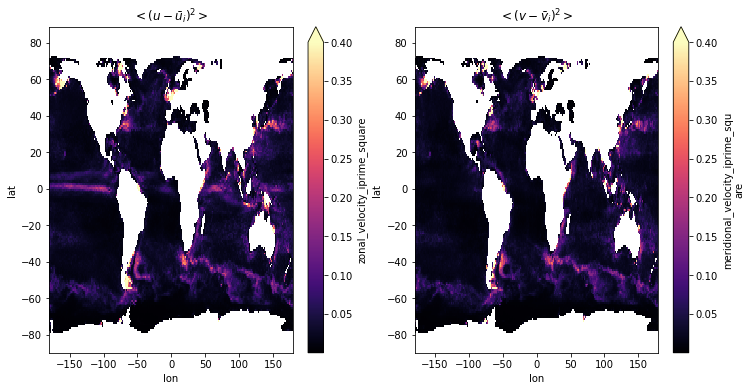

In [25]:
columns = ['zonal_velocity_iprime','meridional_velocity_iprime']
figsize=(6*len(columns),6)
fig,axs = plt.subplots(1,len(columns),figsize=figsize)#,subplot_kw=dict(projection=projection))
for V, ax,title in zip(columns,axs,[r'$<(u-\bar u_i)^2>$',r'$<(v-\bar v_i)^2>$',r'$<(u-\bar u_i)^2+(v-\bar v_i)^2>$']):
    df_mean[V+'_square'].plot(ax=ax,x='lon',vmax=0.4,cmap='magma')
    ax.set_title(title)

#### EKE : binned mean, $<u_b'^2>=<(u-<u>)^2>$
$<.>$ : average over bin and time


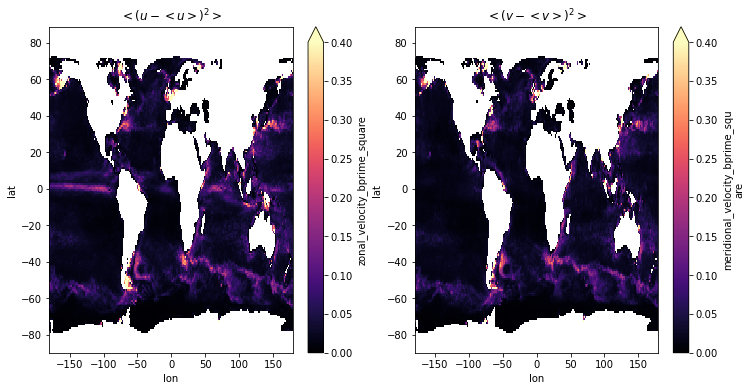

In [26]:
columns = ['zonal_velocity_bprime','meridional_velocity_bprime']
figsize=(6*len(columns),6)
fig,axs = plt.subplots(1,len(columns),figsize=figsize)#,subplot_kw=dict(projection=projection))
for V, ax,title in zip(columns,axs,[r'$<(u-<u>)^2>$',r'$<(v-<v>)^2>$',r'$<(u-\bar u_b)^2+(v-\bar v_b)^2>$']):
    df_mean[V+'_square'].plot(ax=ax,x='lon',vmax=0.4,cmap='magma')
    ax.set_title(title)

#### rms : interpolated mean, $\sqrt{<u_i'^2>}=\sqrt{<(u-\bar u_i)^2>}$
$<.>$ : average over bin and time

$\bar .$ : temporal average

Text(0.5, 1.0, '$\\sqrt{<(u-\\bar u_i)^2+(v-\\bar v_i)^2>}$')

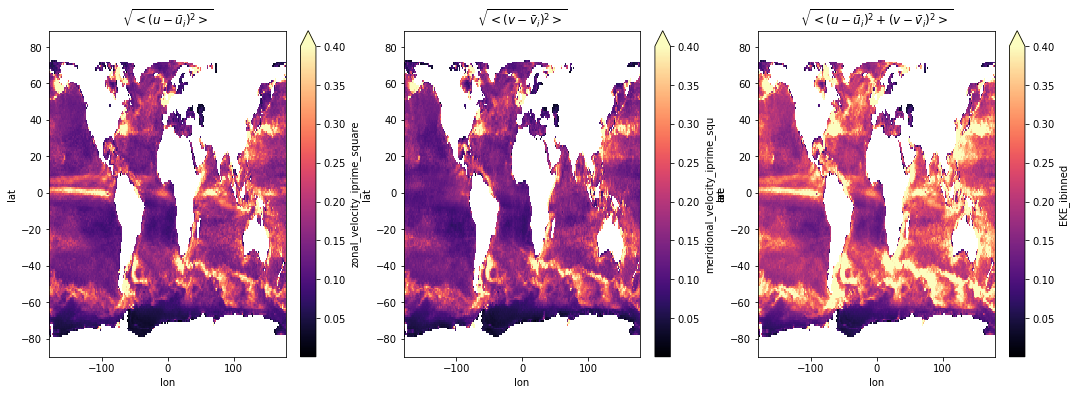

In [29]:
columns = ['zonal_velocity_iprime','meridional_velocity_iprime','EKE_ibinned']
titles  =[r'$\sqrt{<(u-\bar u_i)^2>}$',r'$\sqrt{<(v-\bar v_i)^2>}$',r'$\sqrt{<(u-\bar u_i)^2+(v-\bar v_i)^2>}$']
figsize=(6*len(columns),6)
fig,axs = plt.subplots(1,len(columns),figsize=figsize)#,subplot_kw=dict(projection=projection))
for V, ax, title in zip(columns[:-1],axs,titles):
    np.sqrt(df_mean[V+'_square']).plot(ax=ax,x='lon',vmax=0.4,cmap='magma')
    ax.set_title(title)
np.sqrt(df_mean[columns[-1]]).plot(ax=axs[-1],x='lon',vmax=0.4,cmap='magma')
axs[-1].set_title(titles[-1])

#### rms : binned mean, $\sqrt{<u_b'^2>}=\sqrt{<(u-\bar u_b)^2>}$
$<.>$ : average over bin and time

$\bar .$ : temporal and binned average

Text(0.5, 1.0, '$\\sqrt{<(u-<u>)^2+(v-<v>)^2>}$')

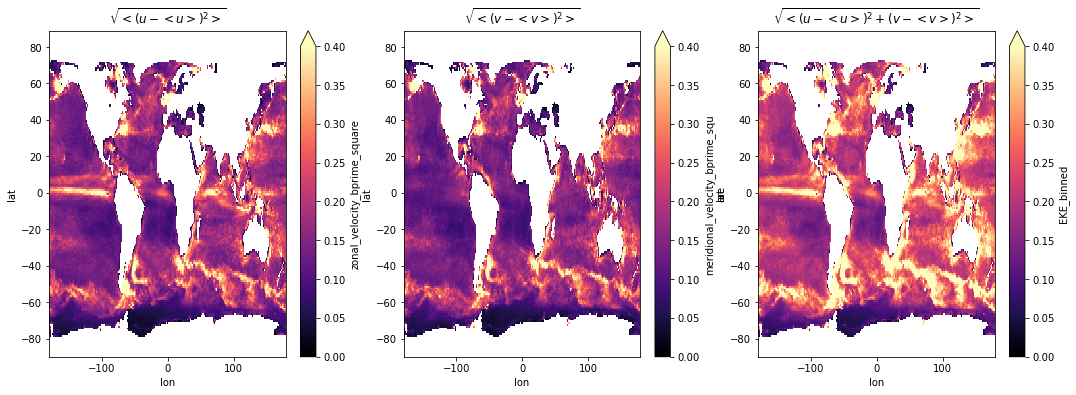

In [30]:
columns = ['zonal_velocity_bprime','meridional_velocity_bprime','EKE_binned']
titles = [r'$\sqrt{<(u-<u>)^2>}$',r'$\sqrt{<(v-<v>)^2>}$',r'$\sqrt{<(u-<u>)^2+(v-<v>)^2>}$']
figsize=(6*len(columns),6)
fig,axs = plt.subplots(1,len(columns),figsize=figsize)#,subplot_kw=dict(projection=projection))
for V, ax, title in zip(columns[:-1],axs,titles):
    np.sqrt(df_mean[V+'_square']).plot(ax=ax,x='lon',vmax=0.4,cmap='magma')
    ax.set_title(title)
np.sqrt(df_mean[columns[-1]]).plot(ax=axs[-1],x='lon',vmax=0.4,cmap='magma')
axs[-1].set_title(titles[-1])

### Total kinetic energy : 

Text(0.5, 1.0, '$<u^2+v^2>$')

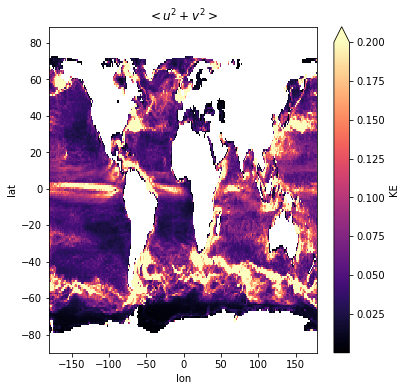

In [35]:
fig,ax=  plt.subplots(figsize=(6,6))
df_mean['KE'].plot(ax=ax,x='lon',vmax=0.2,cmap='magma')
ax.set_title(r'$<u^2+v^2>$')

### Mean kinetic energy

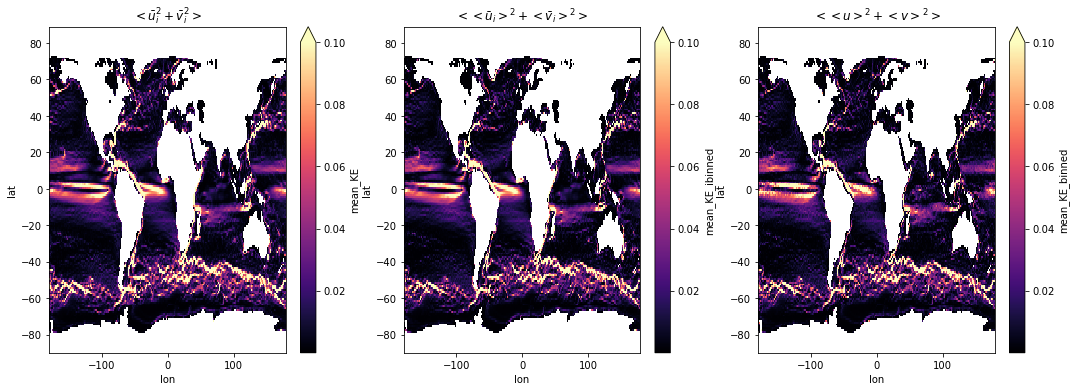

In [31]:
columns = ['mean_KE','mean_KE_ibinned','mean_KE_binned']
titles = [r'$<\bar u_i^2+\bar v_i^2>$',r'$<<\bar u_i>^2+<\bar v_i>^2>$',r'$<<u>^2+<v>^2>$']
figsize=(6*len(columns),6)
fig,axs = plt.subplots(1,len(columns),figsize=figsize)#,subplot_kw=dict(projection=projection))
for V, ax,title in zip(columns,axs,titles):
    df_mean[V].plot(ax=ax,x='lon',vmax=0.1,cmap='magma')
    ax.set_title(title)

### EKE

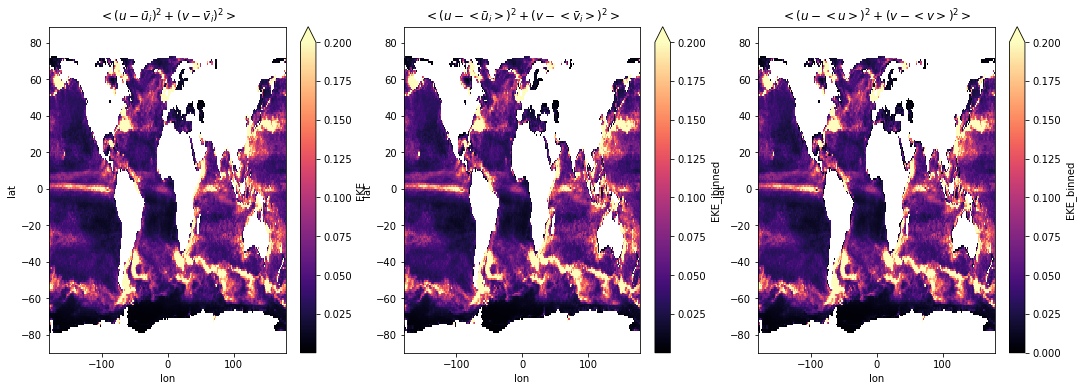

In [33]:
columns = ['EKE','EKE_ibinned','EKE_binned']
titles = [r'$<(u-\bar u_i)^2+(v-\bar v_i)^2>$',r'$<(u-<\bar u_i>)^2+(v-<\bar v_i>)^2>$',r'$<(u-<u>)^2+(v-<v>)^2>$']
figsize=(6*len(columns),6)
fig,axs = plt.subplots(1,len(columns),figsize=figsize)#,subplot_kw=dict(projection=projection))
for V, ax,title in zip(columns,axs,titles):
    df_mean[V].plot(ax=ax,x='lon',vmax=0.2,cmap='magma')
    ax.set_title(title)

In [36]:
cluster.close()